In [2]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 493118, done.
remote: Counting objects: 100% (6728/6728), done.
remote: Compressing objects: 100% (475/475), done.
remote: Total 493118 (delta 6304), reused 6638 (delta 6240), pack-reused 486390
Receiving objects: 100% (493118/493118), 955.97 MiB | 42.68 MiB/s, done.
Resolving deltas: 100% (459551/459551), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [3]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import cv2
import torch
import torchvision
import PIL

from torchvision import transforms, datasets
from torchvision.models.detection import *
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

# For image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# As the data directory contains .xml files
from xml.etree import ElementTree as et

import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import numpy as np
import torch
import PIL.Image

class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, mode='train'):
        self.root = root
        self.transforms = transforms
        self.mode = mode
        self.image_folder = os.path.join(root, "images", mode)
        self.label_folder = os.path.join(root, "labels", mode)
        self.image_files = sorted(os.listdir(self.image_folder))
        self.label_files = sorted(os.listdir(self.label_folder))
        
        # Defining classes, a blank class is given for the background
        self.classes_ = [_,'negative', 'positive']
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        
        # Reading the image
        img = PIL.Image.open(img_path)
        img = img.resize((224, 224))  # Resize to 224x224

        # If the image is grayscale, convert it to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Load annotation file
        ann_name = img_name[:-4] + '.txt'  # Annotation file extension is '.txt'
        ann_path = os.path.join(self.label_folder, ann_name)
        
        with open(ann_path, 'r') as file:
            lines = file.readlines()

        # Initialize lists to store multiple bounding boxes and labels
        boxes = []
        labels = []

        for line in lines:
            data = line.strip().split()
            
            # Extract label and YOLO format data
            label = int(data[0])+1
            yolo_data = list(map(float, data[1:]))
            
            # Convert YOLO format to Faster R-CNN format
            x_center, y_center, width_ratio, height_ratio = yolo_data
            img_width = img.size[0]
            img_height = img.size[1]
            x1 = (x_center - width_ratio / 2) * img_width
            y1 = (y_center - height_ratio / 2) * img_height
            x2 = (x_center + width_ratio / 2) * img_width
            y2 = (y_center + height_ratio / 2) * img_height
            
            # Append bounding box and label to lists
            boxes.append([x1, y1, x2, y2])
            labels.append(label)
        
        # Convert lists to numpy arrays
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # The target is given as a dict
        target = {'boxes': boxes, 'area': area, 'labels': labels, 
                'iscrowd': iscrowd, 'image_id':idx}
        
        if self.transforms:
            img_np = np.array(img)  # Convert image to numpy array
            sample = self.transforms(image=img_np, bboxes=target['boxes'], labels=target['labels'])
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        return img, target


In [5]:
# Create datasets
train_dataset = BrainTumorDataset(root='/kaggle/input/brain-tumo/axial_t1wce_2_class', mode='train')
test_dataset = BrainTumorDataset(root='/kaggle/input/brain-tumo/axial_t1wce_2_class', mode='test')

In [6]:
print('length of dataset = ', len(train_dataset), '\n')

length of dataset =  296 



In [7]:
img, target = train_dataset[0]
print(img.size, '\n',target)

(224, 224) 
 {'boxes': tensor([[ 79.9250,  64.1501, 112.2630,  97.8028]]), 'area': tensor([1088.2583]), 'labels': tensor([1]), 'iscrowd': tensor([0]), 'image_id': 0}


In [8]:
def plot_img_bbox(img, target):
    
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

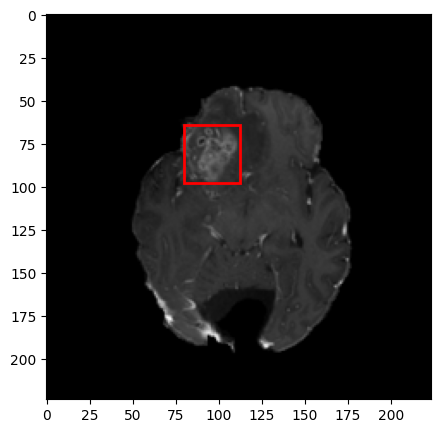

In [9]:
img, target = train_dataset[0]
plot_img_bbox(img, target)

In [10]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [11]:
# Create Faster R-CNN model
def get_object_detection_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [12]:
def get_transform(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [13]:
# Create datasets
train_dataset = BrainTumorDataset(root='/kaggle/input/brain-tumo/axial_t1wce_2_class', transforms=get_transform(train=True),mode='train')
test_dataset = BrainTumorDataset(root='/kaggle/input/brain-tumo/axial_t1wce_2_class',transforms=get_transform(train=False) ,mode='test')

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=utils.collate_fn)  # Imported form helper library
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=utils.collate_fn)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 3 
num_epochs = 9

def start_training(num_epochs, num_classes):
    model = get_model(num_classes)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)
    
    # Learning rate decreases by 10 every 5 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=5)
        lr_scheduler.step()
        evaluate(model, dataloader_test, device=device)
    return model

In [15]:
fast_rcnn = start_training(num_epochs, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 167MB/s]  


Epoch: [0]  [ 0/37]  eta: 0:01:44  lr: 0.000144  loss: 0.9872 (0.9872)  loss_classifier: 0.8086 (0.8086)  loss_box_reg: 0.1075 (0.1075)  loss_objectness: 0.0665 (0.0665)  loss_rpn_box_reg: 0.0046 (0.0046)  time: 2.8232  data: 0.2916  max mem: 5771
Epoch: [0]  [ 5/37]  eta: 0:00:36  lr: 0.000838  loss: 0.7803 (0.7953)  loss_classifier: 0.6076 (0.6193)  loss_box_reg: 0.0989 (0.1039)  loss_objectness: 0.0665 (0.0682)  loss_rpn_box_reg: 0.0039 (0.0038)  time: 1.1376  data: 0.0646  max mem: 5930
Epoch: [0]  [10/37]  eta: 0:00:26  lr: 0.001531  loss: 0.4481 (0.5771)  loss_classifier: 0.2902 (0.4131)  loss_box_reg: 0.1089 (0.1096)  loss_objectness: 0.0419 (0.0511)  loss_rpn_box_reg: 0.0034 (0.0033)  time: 0.9814  data: 0.0398  max mem: 5930
Epoch: [0]  [15/37]  eta: 0:00:20  lr: 0.002225  loss: 0.4141 (0.5271)  loss_classifier: 0.2134 (0.3545)  loss_box_reg: 0.1215 (0.1287)  loss_objectness: 0.0306 (0.0412)  loss_rpn_box_reg: 0.0022 (0.0027)  time: 0.9234  data: 0.0330  max mem: 5930
Epoch: [

In [79]:
def apply_nms(prediction, threshold):
    # torchvision returns the indices of the boxes to keep
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# Function to convert a torch tensor to a PIL Image
def tensorToPIL(img):
    return transforms.ToPILImage()(img).convert('RGB')

In [80]:
# pick one image from the test set
img, target = test_dataset[12]

# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  2
real #boxes:  1


In [94]:
def show_label( label):
    if label == 1 :
            label_text = 'negative'
    else:
            label_text = 'positive'
    return label_text

EXPECTED OUTPUT
negative


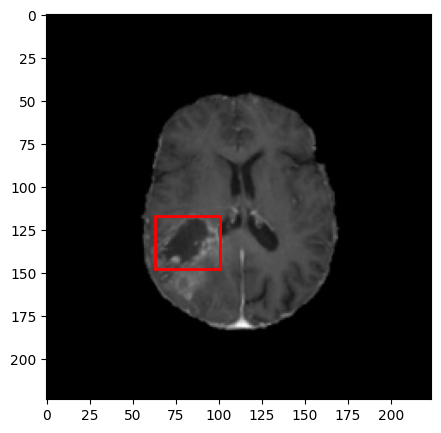

In [95]:
print('EXPECTED OUTPUT')
print(show_label(target['labels'].numpy()))
plot_img_bbox(tensorToPIL(img), target)

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_img_bbox_predict(img, target):
    # Unpack prediction tensors
    boxes = target['boxes'].cpu().numpy()
    labels = target['labels'].cpu().numpy()
    scores = target['scores'].cpu().numpy()
    
    # Plot the image and bounding boxes
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    ax.imshow(img)

    for i in range(len(boxes)):
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        # Add the bounding box to the plot
        ax.add_patch(rect)
        if label == 1 :
            label_text = 'negative'
        else:
            label_text = 'positive'
        
        # Add label and score as text
        ax.text(x, y - 5, f'Label: {label_text}, Score: {score:.2f}', color='red')

    plt.show()


MODEL OUTPUT


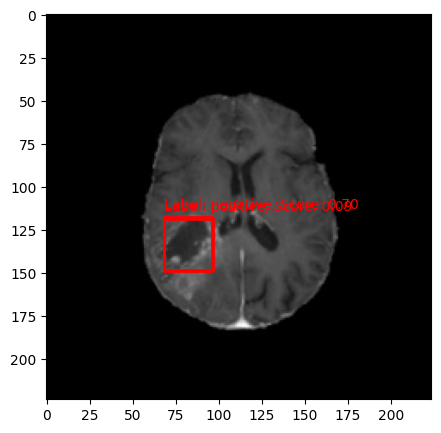

In [83]:
print('MODEL OUTPUT')
plot_img_bbox_predict(tensorToPIL(img), prediction)

In [84]:
print(prediction)
print(target)

{'boxes': tensor([[ 68.1958, 117.6471,  95.8329, 149.0616],
        [ 68.0104, 118.5250,  96.4240, 148.4165]], device='cuda:0'), 'labels': tensor([1, 2], device='cuda:0'), 'scores': tensor([0.7033, 0.0925], device='cuda:0')}
{'boxes': tensor([[ 62.8358, 116.7324, 100.4320, 147.4930]]), 'area': tensor([1156.4797]), 'labels': tensor([1]), 'iscrowd': tensor([0]), 'image_id': 12}


NMS APPLIED MODEL OUTPUT


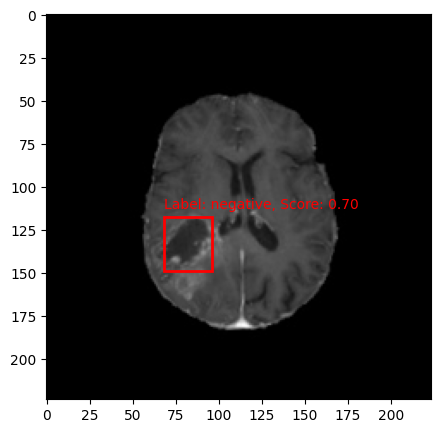

In [85]:
nms_preds = apply_nms(prediction, threshold=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox_predict(tensorToPIL(img), nms_preds)

In [78]:
fast_rcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(